In [134]:
import tensorflow as tf
import IPython.display as display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import tensorflow_probability as tfp
import numpy as np
import PIL.Image
import time
import functools

In [135]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [157]:
# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = 'style.jpg'

In [137]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

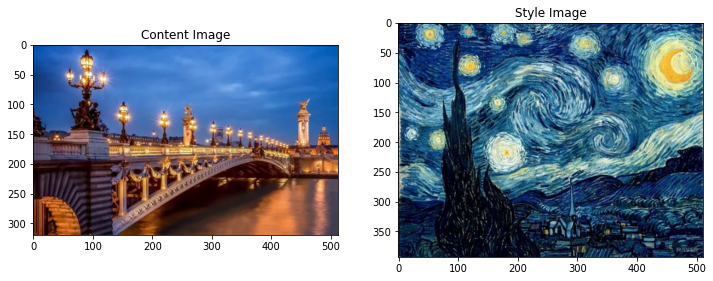

In [138]:

content_image = load_img('/content/paris.jpg')
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

Content와 Style Representation을 얻기 위해서 레이어 중간마다 결과를 확인해보면
초기 레이어에서는 선분이나 질감 같은 저차원적 특성을 나타낸다면 레이어가 깊어질 수록 고차원적인 특성을
나타냅니다.
Resnet50을 모델을 사용했으며 아래 코드는 제대로 모델이 불러와졌고 잘 동작하는지 확인하는 코드입니다.


In [139]:
x = tf.keras.applications.resnet50.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
resnet = tf.keras.applications.ResNet50(include_top=True, weights='imagenet')
prediction_probabilities = resnet(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [140]:
predicted_top_5 = tf.keras.applications.resnet50.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('steel_arch_bridge', 0.7759374),
 ('pier', 0.16371739),
 ('palace', 0.035628945),
 ('suspension_bridge', 0.0072590876),
 ('gondola', 0.003936191)]

In [141]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
for layer in resnet.layers:
  print(layer.name)

input_22
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3

VGG모델과 다르기 때문에 아무 레이어나 가져와서는 안되며 적절한 시도를 통해 레이어와 하이퍼파라미터를 가져와야합니다.
저는 여기서 아래와 같은 레이어에 관심을 갖고 볼 것입니다.

In [142]:
content_layers = ['conv1_conv']

style_layers = ['conv2_block2_1_bn',
                'conv2_block3_2_bn',
                'conv3_block1_1_bn',
                'conv4_block4_3_conv',
                'conv5_block1_1_bn']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [143]:
def resnet_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 resnet 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 resnet 모델을 불러옵니다
  resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
  resnet.trainable = False

  outputs = [resnet.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([resnet.input], outputs)
  return model

In [144]:
style_extractor = resnet_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

conv2_block2_1_bn
  크기:  (1, 99, 128, 64)
  최솟값:  -10.243416
  최댓값:  8.3556385
  평균:  -0.5847095

conv2_block3_2_bn
  크기:  (1, 99, 128, 64)
  최솟값:  -8.753389
  최댓값:  10.733595
  평균:  -0.031137088

conv3_block1_1_bn
  크기:  (1, 50, 64, 128)
  최솟값:  -8.587857
  최댓값:  6.3957415
  평균:  -0.2482039

conv4_block4_3_conv
  크기:  (1, 25, 32, 1024)
  최솟값:  -1.352776
  최댓값:  1.4150288
  평균:  -0.057129912

conv5_block1_1_bn
  크기:  (1, 13, 16, 512)
  최솟값:  -5.383533
  최댓값:  5.7246428
  평균:  -0.62702715



Computing style loss is a bit more involved, but follows the same principle, this time feeding our network the input image (generated image) $x$ and the style image $a$. However, instead of comparing the raw intermediate outputs of the base input image and the style image, we instead compare the Gram matrices of the two outputs.
Mathematically, we describe the style loss of the input image (generated image), $x$, and the style image, $a$, as the distance between the style representation (the gram matrices) of these images. We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix $G^l$, where $G^l_{ij}$ is the inner product between the vectorized feature map $i$ and $j$ in layer $l$. We can see that $G^l_{ij}$ generated over the feature map for a given image represents the correlation between feature maps $i$ and $j$.

각각의 이미지 content는 레이어 중간중간 특성 맵의 값들로 표현이 됩니다.
이 때 각 특성들간의 관계를 정의를 해보는 겁니다. Singular value
이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있습니다.
이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의
외적을 구한 후,평균값을 냄으로써 구할 수 있습니다.
![gram](img/gram.png)
<center><img src="img/einsum.png" width="70%" height="70%"></center>

In [145]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


In [146]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.resnets = resnet_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.resnets.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.resnet50.preprocess_input(inputs)
    outputs = self.resnets(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [147]:
#style_layers의 스타일과 content_layers의 콘텐츠에 대한 그람 행렬을 출력

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   conv2_block2_1_bn
    크기:  (1, 64, 64)
    최솟값:  -2.8098884
    최댓값:  4.489362
    평균:  0.20205736

   conv2_block3_2_bn
    크기:  (1, 64, 64)
    최솟값:  -4.4737535
    최댓값:  6.620294
    평균:  0.009600839

   conv3_block1_1_bn
    크기:  (1, 128, 128)
    최솟값:  -3.3568225
    최댓값:  6.7451653
    평균:  0.037060443

   conv4_block4_3_conv
    크기:  (1, 1024, 1024)
    최솟값:  -0.23789163
    최댓값:  0.30291772
    평균:  0.007234933

   conv5_block1_1_bn
    크기:  (1, 512, 512)
    최솟값:  -2.3504443
    최댓값:  5.7878594
    평균:  0.56891024

콘텐츠:
   conv1_conv
    크기:  (1, 160, 256, 64)
    최솟값:  -799.6402
    최댓값:  850.3823
    평균:  1.4511111


In [148]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


In [149]:
#최적화시킬 이미지를 담을 tf.Variable을 정의하고 콘텐츠 이미지로 초기화 (이때 tf.Variable는 콘텐츠 이미지와 크기가 같아야 함.
image = tf.Variable(content_image)

In [150]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [151]:
#LBFGS를 추천하지만, Adam도 충분히 적합
opt = tf.optimizers.Adam()

In [152]:
style_weight=1e9
content_weight=1
total_variation_weight=2

In [153]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

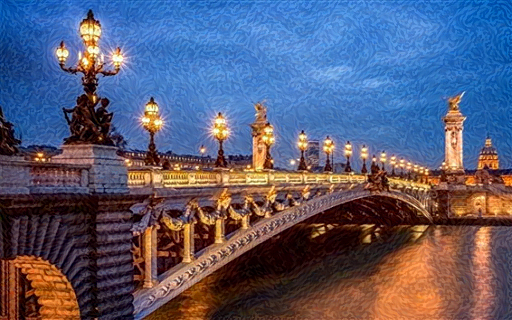

In [154]:
# @tf.function()
# def train_step(image):
#   with tf.GradientTape() as tape:
#     outputs = extractor(image)
#     loss = style_content_loss(outputs)
#
#   grad = tape.gradient(loss, image)
#   opt.apply_gradients([(grad, image)])
#   image.assign(clip_0_1(image))

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
for _ in range(100):
    train_step(image)
tensor_to_image(image)

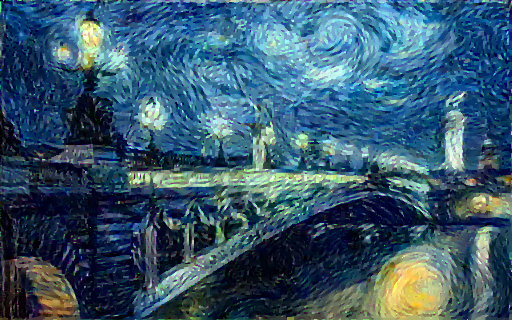

훈련 스텝: 100000
전체 소요 시간: 1735.7


In [155]:
import time
start = time.time()

epochs = 1000
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))


In [156]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>